TO DO:

- find out why command in step 2 does not work
- update steps 4+
    - find out how long the each motion is and edit tmin and tmax to reflect this
    - write the code to align the peaks of all the epochs
    - average these epochs to create the mask/filter used to detect the motion

DONE:

- update steps 1-3
- update psychopy_presentations/moving_hand with our own images/prompts

In [1]:
from muselsl import stream, view, record
from multiprocessing import Process
from mne import Epochs, find_events
from time import time, strftime, gmtime
import os
import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

### Update these variables to incorporate different motions/signals

In [2]:
# more specific motions
from psychopy_presentations import moving_hand

# name of the folder in data to put the .csv files in
# folder will be placed inside the data folder
motion_type = "moving_hand"

# name of the function that presents images/prompts using psychopy
motion_function = moving_hand.present

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


### Update these parameters to define the length of the experiment and the subject name/session number of the experiment

In [4]:
# parameters for the experiment 
duration = 30 # in seconds. 120 is recommended
subject = 1 # unique id for each participant
session = 1 # represents a data collection session. Multiple trials can be performed for each session

## Step 1: Connect to an EEG Device

    - Open BlueMuse
    - Connect to Muse
    - Start Streaming
    - Put the Muse on

## Step 2: Apply the EEG Device and Wait for Signal Quality to Stabilize

The numbers on the side of the graph indicate the variance of the signal. Wait until this decreases below 10 for all electrodes before proceeding.

In [ ]:
# On Windows, you may need to replace this with the command %matplotlib tk
%matplotlib

#view(version = 2) # does not respond for some reason. use muselsl view --version 2 on cmd instead

## Step 3: Run the Experiment

Seat the subject in front of the computer and run the following cell to run a single trial of the experiment. Each experiment will create a .csv file in the `data` folder that has `duration` amount of seconds of EEG data, which will have multiple events depending on the psychopy presentation function.

In order to maximize the possibility of success, participants should take the experiment in a quiet environment and do their best to minimize movement that might contaminate the signal. With their jaw and face relaxed, subjects should focus on the stimuli.

In [ ]:
recording_path = os.path.join(".", "data", motion_type, 
                              "subject_" + str(subject), 
                              "session_" + str(session), 
                              ("recording_%s" % strftime("%Y-%m-%d-%H.%M.%S", gmtime())) + ".csv")

stimulus = Process(target=motion_function, args=(duration,))
recording = Process(target=record, args=(duration, recording_path))

stimulus.start()
recording.start()

### Repeat Data Collection 3-6 times

Visualizing ERPs requires averaging the EEG response over many different rounds of stimulus presentation. Depending on experimental conditions, this may require as little as one two minute trial or as many as 6. We recommend repeating the above experiment 3-6 times before proceeding. 

Make sure to take breaks, though! Inattention, fatigue, and distraction will decrease the quality of event-related potentials.

## Step 4: Prepare the Data for Analysis

Once a suitable data set has been collected, it is now time to analyze the data and see if we can identify the N170


### Load data into MNE objects

[MNE](https://martinos.org/mne/stable/index.html) is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step to using MNE is to read the data we've collected into an MNE `Raw` object

In [5]:
raw = utils.load_data('./data/' + motion_type, sfreq=256., 
                      subject_nb = subject, session_nb = session)

Creating RawArray with float64 data, n_channels=5, n_times=2400
    Range : 0 ... 2399 =      0.000 ...     9.371 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=7524
    Range : 0 ... 7523 =      0.000 ...    29.387 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=7524
    Range : 0 ... 7523 =      0.000 ...    29.387 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=7524
    Range : 0 ... 7523 =      0.000 ...    29.387 secs
Ready.


### Visualizing the Power Spectrum

Plotting the power spectral density (PSD) of our dataset will give us a glimpse at the different frequencies that are present. We won't be able to see the P300 in the PSD, but it will give us an impression of how noisy our data was. A very noisy or flat PSD may represent poor signal quality at certain electrodes



Effective window size : 8.000 (s)


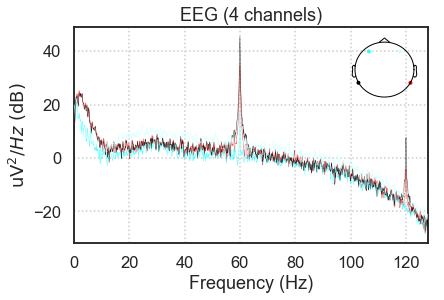

In [6]:
%matplotlib inline
raw.plot_psd();

This PSD looks good. There is a tremendous peak at 50hz and it's harmonic at 100hz. You can tell this dataset was collected in Europe because of the 50hz line noise

### Filtering

Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.

Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Effective window size : 8.000 (s)


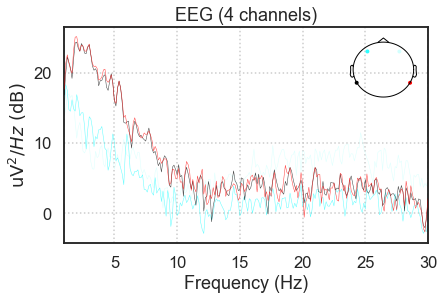

In [7]:
raw.filter(1,30, method='iir')
raw.plot_psd(fmin=1, fmax=30);

This PSD looks great. The AF8 electrode (Front right; light green) seems to have some noise in the signal, but the TP9 and TP10 electrodes (red and black) look great

### Epoching

Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus. No baseline correction is needed (signal is bandpass filtered) and we will reject every epoch where the amplitude of the signal exceeded 75 uV, which should most eye blinks.

In [11]:
events = find_events(raw)
event_id = {'Target': 1}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=1, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

12 events found
Event IDs: [1]
sample drop %:  33.333333333333336


<Epochs  |   8 events (all good), -0.101562 - 1 sec, baseline off, ~87 kB, data loaded,
 'Target': 8>

Sample drop % is an important metric representing how noisy our data set was. If this is greater than 20%, consider ensuring that signal variances is very low in the raw EEG viewer and collecting more data

## Step 5: Analyze the Data

Finally, we can now analyze our results by averaging the epochs that occured during the different stimuli and looking for differences in the waveform


### Epoch average

With our `plot_conditions` utility function, we can plot the average ERP for all electrodes for both conditions:

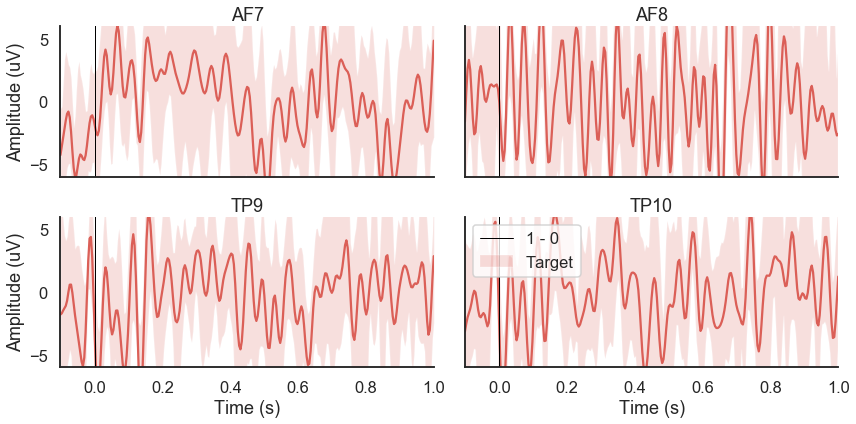

In [15]:
%matplotlib inline
conditions = OrderedDict()
conditions['Target'] = [1]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(0, 1))

Here we can see a beautiful negative deflection in the EEG around 350ms after presentation of Target stimuli. The fact that it's occuring ~50ms later than expected is probably due to delay introduced by transmitting the data over bluetooth.

But wait, isn't this supposed to be a positive ERP? Well, yes, but the Muse's reference electrode is in a different location than traditional EEG systems (at the very front of the forehead instead of the top of the head or near the ear). Because of the location of the source of the P300 signal in the brain, this means that the direction of the P300 potential is inverted

### Decoding the N170

Next, we will use 4 different machine learning pipelines to classify the P300 based on the data we collected.

- **Vect + LR** :  Vectorization of the trial + Logistic Regression. This can be considered the standard decoding pipeline for MEG / EEG.
- **Vect + RegLDA** :  Vectorization of the trial + Regularized LDA. This one is very commonly used in P300 BCIs. It can outperform the previous one but become unusable if the number of dimension is too high.
- **ERPCov + TS**: ErpCovariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipeline.
- **ERPCov + MDM**: ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.

Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

*Note: because we're doing machine learning here, the following cell may take a while to complete*

In [ ]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()

The best classifier for this dataset was ERP Covariance + MDM, which achieved an accuracy of around 0.77. This could be considered good enough for a BCI application, though one shouldn't expect outstanding results

## Step 6: Share your Data!

How did your experiment go? If you're excited by your results we'd love to see your data!

Follow the instructions on our [Contributions](https://github.com/NeuroTechX/eeg-notebooks/blob/master/CONTRIBUTING.md) page to make a pull request with your data and we'll review it to be added to the EEG notebooks project.

In [ ]:
import numpy as np


In [ ]:

np.random.binomial(2, 0.6, 10)